### Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Import data into tensorflow dataset object

In [2]:
# Constants
IMAGE_SIZE = 224  # Replace with your desired image size
BATCH_SIZE = 32
DATASET_DIR = '/kaggle/input/riceleaf/Dataset4'  # Path to your dataset directory
CLASS_NAMES = os.listdir(DATASET_DIR)

# Prepare a list of all image paths and corresponding labels
image_paths = []
labels = []

for class_name in CLASS_NAMES:
    class_dir = os.path.join(DATASET_DIR, class_name)
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(class_name)

# Create a DataFrame
data = pd.DataFrame({'image_path': image_paths, 'label': labels})


In [3]:
# Split into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.1, stratify=data['label'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.125, stratify=train_data['label'], random_state=42)  # 0.25 x 0.8 = 0.2


In [4]:
# Data Augmentation and Data Generators
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True
)

train_generator = datagen.flow_from_dataframe(
    train_data,
    x_col='image_path',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = datagen.flow_from_dataframe(
    val_data,
    x_col='image_path',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = datagen.flow_from_dataframe(
    test_data,
    x_col='image_path',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important to maintain order for evaluation
)

Found 4670 validated image filenames belonging to 4 classes.
Found 668 validated image filenames belonging to 4 classes.
Found 594 validated image filenames belonging to 4 classes.


In [5]:
# Get class indices
class_indices = train_generator.class_indices

# Map class names to their image counts
class_counts_dict = train_data['label'].value_counts().to_dict()

# Create a list of counts in the order of train_generator.class_indices
ordered_counts = [(class_name, class_counts_dict.get(class_name, 0)) for class_name in class_indices.keys()]

# Convert to a DataFrame for better visualization
ordered_counts_df = pd.DataFrame(ordered_counts, columns=['Class Name', 'Image Count'])

# Print the ordered counts
print(ordered_counts_df)



        Class Name  Image Count
0  Bacterialblight         1246
1            Blast         1134
2        Brownspot         1260
3           Tungro         1030


## Building the Model

In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from keras.layers import Flatten, Dense

strategy=tf.distribute.MirroredStrategy()
with strategy.scope():
    
    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in vgg_base.layers:
        layer.trainable = False
    
    # Add custom layers on top of the VGG16 base
    x = vgg_base.output
    x = tf.keras.layers.GlobalAveragePooling2D()(vgg_base.output)
    x = Dense(32, activation='relu')(x)  # Custom fully connected layer
    x = Dense(4, activation='softmax')(x)  # Output layer for 4 classes
    
    # Create the complete model
    model = Model(inputs=vgg_base.input, outputs=x)
        
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','Precision', 'Recall'])

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          16,4

 Total params: 14,731,236 (56.20 MB)

 Trainable params: 16,548 (64.64 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [7]:
history = model.fit(
    train_generator,
    batch_size=32,
    validation_data=validation_generator,
    epochs=30
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


146/146 ━━━━━━━━━━━━━━━━━━━━ 101s 606ms/step - Precision: 0.7467 - Recall: 0.1079 - accuracy: 0.4837 - loss: 1.2014 - val_Precision: 0.8760 - val_Recall: 0.6347 - val_accuracy: 0.7665 - val_loss: 0.7159
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 66s 433ms/step - Precision: 0.8591 - Recall: 0.6653 - accuracy: 0.7595 - loss: 0.6561 - val_Precision: 0.8412 - val_Recall: 0.6976 - val_accuracy: 0.7844 - val_loss: 0.5687
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 65s 428ms/step - Precision: 0.8779 - Recall: 0.7458 - accuracy: 0.8154 - loss: 0.4924 - val_Precision: 0.8605 - val_Recall: 0.7754 - val_accuracy: 0.8144 - val_loss: 0.4444
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 66s 431ms/step - Precision: 0.8773 - Recall: 0.7898 - accuracy: 0.8349 - loss: 0.4203 - val_Precision: 0.8737 - val_Recall: 0.7665 - val_accuracy: 0.8323 - val_loss: 0.4378
Epoch 5/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 65s 429ms/step - Precision: 0.9022 - Recall: 0.8184 - accuracy: 0.8617 - loss: 0.3670 - val_Precision: 0.8849 - val_Re

In [8]:
# Evaluate on train data
train_scores = model.evaluate(train_generator, verbose=1)
print(f"Train Loss: {train_scores[0]:.4f}, Train Accuracy: {train_scores[1]:.4f}")

# Evaluate on test data
test_scores = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_scores[0]:.4f}, Test Accuracy: {test_scores[1]:.4f}")


146/146 ━━━━━━━━━━━━━━━━━━━━ 61s 418ms/step - Precision: 0.9780 - Recall: 0.9735 - accuracy: 0.9763 - loss: 0.0792
Train Loss: 0.0803, Train Accuracy: 0.9734
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 648ms/step - Precision: 0.9590 - Recall: 0.9502 - accuracy: 0.9562 - loss: 0.1060
Test Loss: 0.1053, Test Accuracy: 0.9630


In [9]:
from sklearn.metrics import classification_report, accuracy_score,precision_score, recall_score, f1_score


# Get true labels and predicted labels
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = y_pred_probs.argmax(axis=1)  # Convert probabilities to class indices


19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 394ms/step


In [10]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


Classification Report:
                 precision    recall  f1-score   support

Bacterialblight       0.94      0.98      0.96       159
          Blast       0.94      0.89      0.91       144
      Brownspot       0.96      0.96      0.96       160
         Tungro       1.00      1.00      1.00       131

       accuracy                           0.96       594
      macro avg       0.96      0.96      0.96       594
   weighted avg       0.96      0.96      0.96       594



In [11]:
overall_accuracy = accuracy_score(y_true, y_pred)
overall_precision = precision_score(y_true, y_pred, average='weighted')  # Weighted average for class imbalance
overall_recall = recall_score(y_true, y_pred, average='weighted')
overall_f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")
print(f"Overall F1-Score: {overall_f1:.4f}")

Overall Accuracy: 0.9579
Overall Precision: 0.9579
Overall Recall: 0.9579
Overall F1-Score: 0.9576


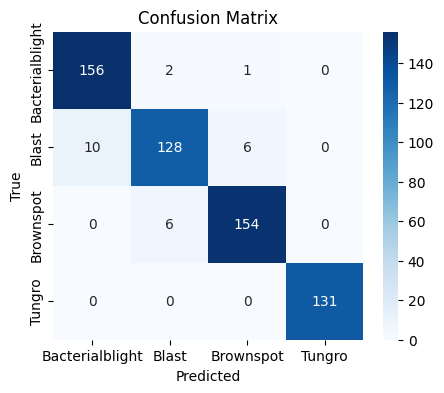

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm= confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [13]:
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Create a DataFrame for the class-wise accuracies
class_accuracy_df = pd.DataFrame({
    "Class": list(test_generator.class_indices.keys()),
    "Accuracy": class_accuracies
})

print("\nClass-wise Accuracies:")
print(class_accuracy_df.to_string(index=False))


Class-wise Accuracies:
          Class  Accuracy
Bacterialblight  0.981132
          Blast  0.888889
      Brownspot  0.962500
         Tungro  1.000000


In [14]:
import numpy as np
specificity = []

for i in range(len(cm)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity.append(tn / (tn + fp))

overall_specificity = np.mean(specificity)  # Average specificity

print(f"Overall Specificity: {overall_specificity:.4f}")

Overall Specificity: 0.9858


In [15]:
# Sensitivity (Recall)
def calculate_specificity(cm, CLASS_NAMES):

    # Specificity
    specificity = []
    for i in range(len(cm)):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity.append(tn / (tn + fp))

    print("\nPer-Class Specificity:")
    for idx, class_name in enumerate(CLASS_NAMES):
        print(f"Class {class_name}: {specificity[idx]:.4f}")

    return specificity

In [16]:
# print("\n--- Train Data Metrics ---")
specificity = calculate_specificity(cm, CLASS_NAMES)


Per-Class Specificity:
Class Tungro: 0.9770
Class Bacterialblight: 0.9822
Class Blast: 0.9839
Class Brownspot: 1.0000


### Run prediction on a sample image

In [17]:
import random
from tensorflow.keras.preprocessing import image

random_indices = random.sample(range(len(y_true)), 15)

class_names = list(test_generator.class_indices.keys())

# Iterate through the random indices and display actual and predicted results
for idx in random_indices:
    actual_class = class_names[y_true[idx]]
    predicted_class = class_names[y_pred[idx]]
    print(f"Actual: {actual_class} ,  Predicted: {predicted_class}")

Actual: Blast ,  Predicted: Blast
Actual: Blast ,  Predicted: Blast
Actual: Brownspot ,  Predicted: Brownspot
Actual: Tungro ,  Predicted: Tungro
Actual: Blast ,  Predicted: Blast
Actual: Blast ,  Predicted: Bacterialblight
Actual: Brownspot ,  Predicted: Brownspot
Actual: Brownspot ,  Predicted: Brownspot
Actual: Bacterialblight ,  Predicted: Bacterialblight
Actual: Blast ,  Predicted: Blast
Actual: Brownspot ,  Predicted: Brownspot
Actual: Blast ,  Predicted: Blast
Actual: Brownspot ,  Predicted: Brownspot
Actual: Brownspot ,  Predicted: Brownspot
Actual: Blast ,  Predicted: Blast
